# Quickstart: Amortized Posterior Estimation

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf
from bayesflow.diagnostics.plot_losses import plot_losses
from bayesflow.diagnostics.plot_recovery import plot_recovery

## Generative Model Definition

The toy Gaussian model we will use for this tutorial takes a particularly simple form:

\begin{align}
    \mathbf{\mu} &\sim \mathcal{N}_D(\mathbf{0}, \sigma_0 \mathbb{I}),\\
    \mathbf{x}_n &\sim \mathcal{N}_D(\mathbf{\mu}, \sigma_1 \mathbb{I}) \quad \text{for } n = 1, ..., N,
\end{align}

where $\mathcal{N}_D$
denotes a multivariate Gaussian (normal) density with $D$
dimensions, which we set at $D = 4$
for the current example. For simplicity, we will also set $\sigma_0 = 1$
and $\sigma_1 = 1$
. We will now implement this model using the latest numpy interface.

In [70]:
def theta_prior():
    theta = np.random.normal(size=4)
    return dict(theta=theta)

def forward_model(theta, n_obs=100):
    x = np.random.normal(loc=theta, size=(n_obs, theta.shape[0]))
    return dict(x=x)

In [71]:
simulator = bf.make_simulator([theta_prior, forward_model])

In [72]:
sample_data = simulator.sample((50,))

In [73]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['theta', 'x'])
Types of sample_data values:
	 {'theta': <class 'numpy.ndarray'>, 'x': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'theta': (50, 4), 'x': (50, 100, 4)}


In [74]:
sample_data

{'theta': array([[-0.25933109, -0.29311586, -0.43468539, -0.75589758],
        [-0.62746534,  0.26783042, -0.54751926, -0.33454591],
        [ 0.48858301, -0.48960682,  0.41613236,  0.38619082],
        [-1.26044397,  0.28186682,  0.16251423,  0.03970525],
        [-0.81672093, -0.33752783,  0.59320318,  0.06854435],
        [-0.8297982 , -0.89704741,  0.82610742,  0.79129585],
        [-0.27320508, -1.24441094,  1.73280939,  2.74006395],
        [-1.25845926, -0.67339622, -0.51586832, -0.64329048],
        [-1.13386794, -0.46101155,  0.20951863, -0.00562751],
        [-0.22513122, -1.57013183, -0.16388857, -0.43789601],
        [-0.81567616,  1.14158432, -0.46095738, -1.04537264],
        [ 0.27219349,  0.48780616, -0.61371472, -1.40612089],
        [-1.27484604,  0.72096922, -0.08216321,  0.06403711],
        [ 1.01779488,  0.971248  , -0.19348285, -0.5629501 ],
        [ 0.11858625, -0.38555645, -0.35270227, -0.9507192 ],
        [ 0.49935472,  0.52885169, -1.24047814,  0.25604984],

In [98]:
data_adapter = bf.ContinuousApproximator.build_adapter(
    inference_variables=["theta"],
    inference_conditions=["x"],
    summary_variables=["x"]
)

In [99]:
# Define hyperparameters
num_training_batches = 1024
num_validation_batches = 256
batch_size = 128

In [100]:
training_samples = simulator.sample((num_training_batches * batch_size, ))
validation_samples = simulator.sample((num_validation_batches * batch_size, ))

training_dataset = bf.datasets.OnlineDataset(
    simulator=simulator, 
    batch_size=batch_size, 
    num_batches=num_training_batches, 
    adapter=data_adapter
)

validation_dataset = bf.datasets.OnlineDataset(
    simulator=simulator,
    batch_size=batch_size,
    num_batches=num_validation_batches,
    adapter=data_adapter
)

In [101]:
summary_network = bf.networks.DeepSet(summary_dim=10)

In [102]:
summary_network.build(input_shape=(50, 100, 4))

In [103]:
inference_network = bf.networks.FlowMatching(
    subnet="mlp",
    optimal_transport_kwargs=dict(
        depth=6,
        width=256,
    ),
)
# inference_network.build()

In [104]:
test_sim = simulator.sample((4,))

In [105]:
approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    summary_network=summary_network,
    adapter=data_adapter,
)

In [106]:
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [107]:
class BatchLossHistory(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = {
            "training_loss": [],
            "validation_loss": [],
        }

    def on_train_batch_end(self, batch, logs=None):
        # 'logs' is a dictionary containing loss and other metrics
        training_loss = logs.get('loss')
        self.losses["training_loss"].append(training_loss)
        
    
    def on_test_batch_end(self, batch, logs=None):
        validation_loss = logs.get('loss')
        self.losses["validation_loss"].append(validation_loss)

In [108]:
approximator.compile(optimizer=optimizer)

In [109]:
batch_loss_history = BatchLossHistory()

In [110]:
history = approximator.fit(
    epochs=10,
    dataset=training_dataset,
    validation_data=validation_dataset,
    callbacks=[batch_loss_history],
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


KeyError: "Missing keys: {'x'}"

In [97]:
import pandas as pd

f = plot_losses(
    train_losses=pd.DataFrame(batch_loss_history.losses["training_loss"]), 
    val_losses=pd.DataFrame(batch_loss_history.losses["validation_loss"])
)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1600x0 with 0 Axes>

In [37]:
n_samples = 5000

conditions = {
    "x": np.array([[0.0, 0.0, 0.0, 0.0]]).astype(np.float32),
}

samples = approximator.sample(conditions=conditions, num_samples=n_samples)

theta_samples = samples["theta"]

In [38]:
theta_samples

array([[[-0.8272288 , -0.49605218,  0.70173615,  0.5919672 ],
        [-0.3977319 ,  0.29412413,  0.4869203 , -0.6501034 ],
        [ 0.36272183, -0.808805  ,  0.0503429 , -0.8143094 ],
        ...,
        [ 0.44116256,  0.22608528,  0.08759339,  1.1507258 ],
        [-0.14893901, -0.90049297,  0.67143995, -0.46183816],
        [ 0.05667248,  0.3298449 ,  0.0929981 , -0.47135326]]],
      dtype=float32)

In [39]:
prior_samples = simulator.sample(conditions=conditions, batch_shape=(n_samples,))

In [40]:
prior_theta_sample = np.zeros((1, n_samples, 4))
prior_theta_sample[0, :] = prior_samples['theta']

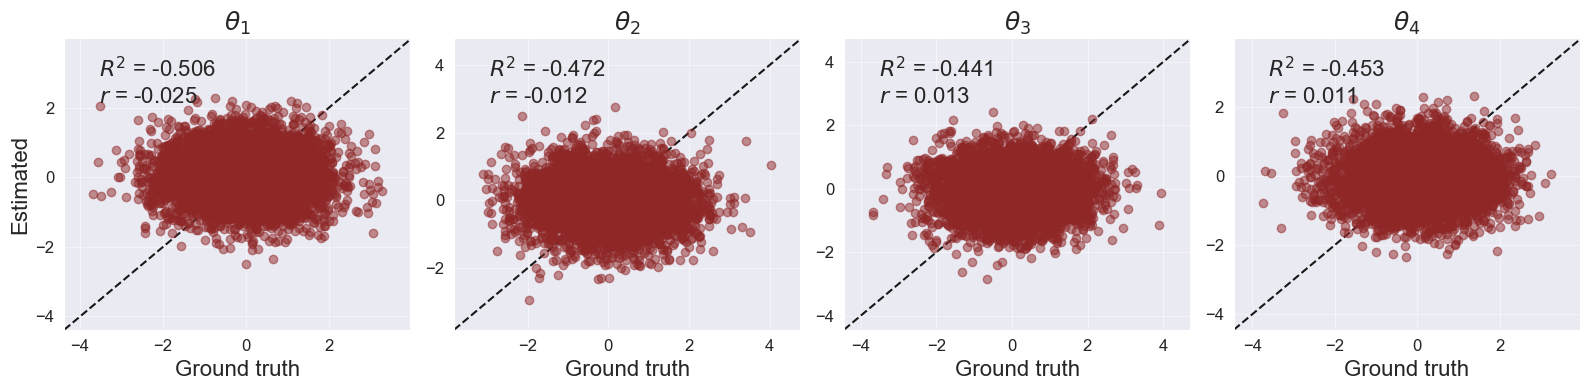

In [41]:
f = plot_recovery(
    post_samples=np.swapaxes(theta_samples, 0, 1), 
    prior_samples=prior_samples['theta']
)